In [1]:
import sys
sys.path.append("../src")
sys.path.append("../models")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *

# custom functions
import config
import helpers
from automl import get_pycaret_model

* 피어슨 상관계수 - 피어슨 상관계수는 두개의 연속적인 변수들 사이의 연관성을 정량화 한 척도이다. 이 연관성을 -1에서 1 사이의 값으로 나타낸다.  
* 카이제곱 - 카이제곱은 모든 피처들에 대한 F-score와 p-value 값을 찾는데 사용된다. F score가 높을수록 변수는 더 중요하다는 것이고 p value가 작을수록 변수는 더 중요하다는 것이다. 이 방법은 데이터셋의 다양한 속성에서 관측된 값을 기댓값과 비교한다.  
* 상호 정보 이득 계수 - 정보 이득은 데이터셋의 변환 이전과 이후의 엔트로피를 비교하여 계산한다. 상호 정보는 두 변수들 사이의 통계적인 의존성을 계산한다.

In [2]:
train = pd.read_csv(config.TRAINING_FILE)
test = pd.read_csv(config.TEST_FILE)
origin = pd.read_csv(config.ORIGINAL_FILE)

In [3]:
categorical_cols = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane','capillary_refill_time','pain',
'peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen',
'abdomo_appearance','lesion_2','surgery', 'age', 'surgical_lesion', 'lesion_3', 'cp_data']
numerical_cols = list(set(train.columns) - set(categorical_cols) - set(["id"]))

In [4]:
print(f"TRAIN SHAPE : {train.shape}")
print(f"TEST SHAPE : {test.shape}")
print(f"ORIGINAL SHAPE : {origin.shape}")

TRAIN SHAPE : (1235, 29)
TEST SHAPE : (824, 28)
ORIGINAL SHAPE : (299, 28)


In [5]:
for col_name in categorical_cols:
    print(col_name)
    print("Number of unique values in train : ", train_orig[col_name].nunique())
    print("Unique values in train : ", train_orig[col_name].unique())
    print("Number of unique values in test : ", test[col_name].nunique())
    print("Unique values in test : ", test[col_name].unique())
    print("*"*50)

temp_of_extremities


NameError: name 'train_orig' is not defined

In [ ]:
# concate training and original data
train_orig = pd.concat(
    [train, origin], ignore_index=True
)
train_orig = train_orig.drop_duplicates()

train_orig["Source"] = ["Train"] * len(train_orig)
test["Source"] = ["Test"] * len(test)

df_all = pd.concat(
    [train_orig, test], ignore_index=True
)

print(df_all.shape)
df_all.head()

(2358, 30)


,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome,Source
0,0.0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,8.5,serosanguious,3.4,yes,2209,0,0,no,died,Train
1,1.0,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized,Train
2,2.0,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,6.4,serosanguious,3.4,yes,5124,0,0,no,lived,Train
3,3.0,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,7.0,cloudy,3.9,yes,2208,0,0,yes,lived,Train
4,4.0,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,7.3,cloudy,2.6,no,0,0,0,yes,lived,Train


In [6]:
# One hot encoding

df_all_dummy = pd.get_dummies(df_all, columns = categorical_cols, dtype=int)
df_all_dummy['outcome'] = df_all_dummy["outcome"].map(
    {'died' : 0,
     'lived' : 1,
     'euthanized' : 2}
)
df_all_dummy.shape

NameError: name 'df_all' is not defined

In [7]:
df_train = (df_all_dummy[df_all_dummy["Source"] == "Train"]
            .drop(["id", "Source"], axis=1)
            .reset_index(drop=True))

df_test = (df_all_dummy[df_all_dummy["Source"] == "Test"]
           .drop(["outcome", "Source"], axis=1)
           .set_index("id"))

print("Train Shape : ", df_train.shape)
print("Test Shape : ", df_test.shape)

NameError: name 'df_all_dummy' is not defined

In [25]:
baseline_best_model = get_pycaret_model(df_train, "outcome")

,Description,Value
0,Session id,1
1,Target,outcome
2,Target type,Multiclass
3,Original data shape,"(1534, 92)"
4,Transformed data shape,"(1534, 92)"
5,Transformed train set shape,"(1073, 92)"
6,Transformed test set shape,"(461, 92)"
7,Numeric features,91
8,Rows with missing values,18.4%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7241,0.8601,0.7241,0.7237,0.7223,0.5522,0.5534,0.2080
rf,Random Forest Classifier,0.7195,0.8586,0.7195,0.7216,0.7173,0.5434,0.5455,0.0820
lightgbm,Light Gradient Boosting Machine,0.7195,0.8590,0.7195,0.7215,0.7180,0.5433,0.5449,0.4720
et,Extra Trees Classifier,0.7092,0.8462,0.7092,0.7089,0.7064,0.5252,0.5266,0.0720
ridge,Ridge Classifier,0.6794,0.0000,0.6794,0.6798,0.6762,0.4759,0.4777,0.0140
lda,Linear Discriminant Analysis,0.6784,0.8313,0.6784,0.6786,0.6764,0.4779,0.4791,0.0160
ada,Ada Boost Classifier,0.6756,0.7853,0.6756,0.6774,0.6754,0.4768,0.4777,0.0420
knn,K Neighbors Classifier,0.6328,0.7634,0.6328,0.6386,0.6319,0.4083,0.4110,0.4920
dt,Decision Tree Classifier,0.6067,0.6802,0.6067,0.6059,0.6044,0.3637,0.3650,0.3720
nb,Naive Bayes,0.5443,0.7437,0.5443,0.5657,0.5053,0.2138,0.2414,0.4400


# 1. Pearson Correlation

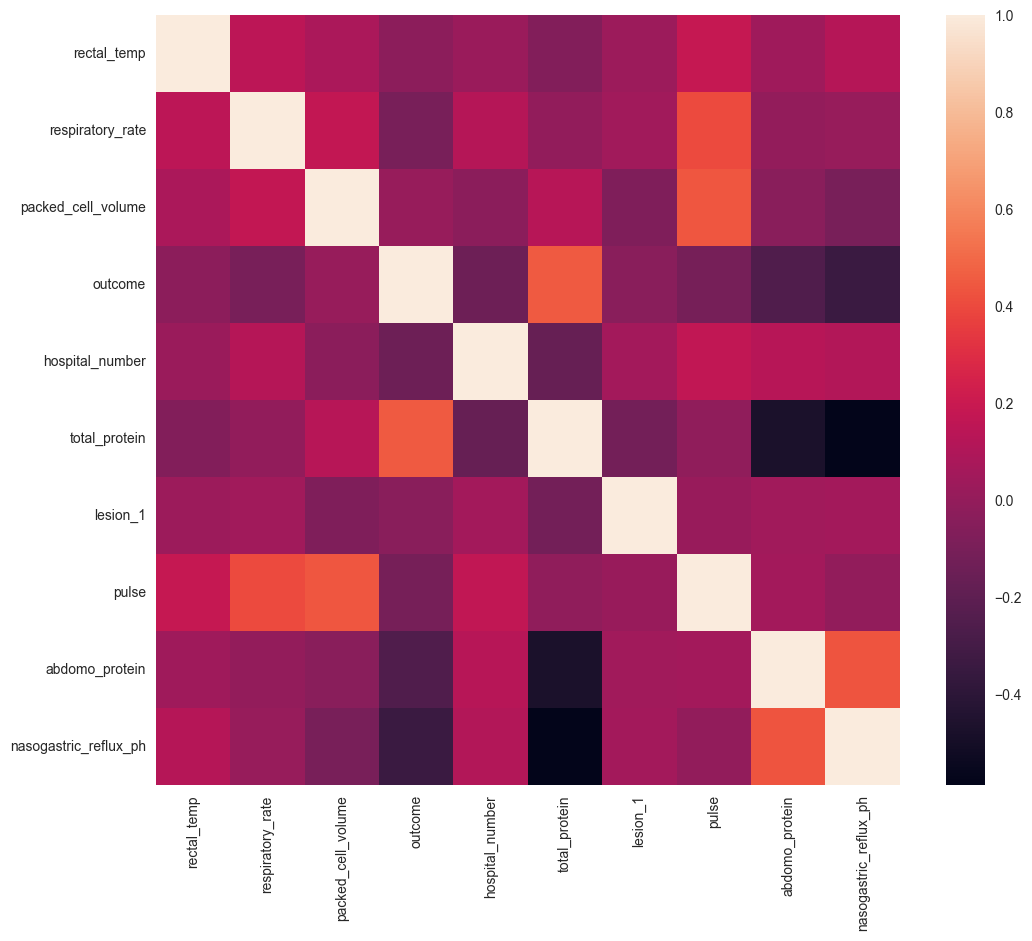

In [26]:
_df = df_train[numerical_cols]
cor = _df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor)
plt.show()

In [31]:
#Finding the correlated features
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr().apply(np.abs)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: 
                colname = corr_matrix.columns[i]                  
                col_corr.add(colname)
    return col_corr      

corr_features = correlation(_df, 0.4)
corr_features

{'abdomo_protein', 'nasogastric_reflux_ph', 'pulse', 'total_protein'}

# 2. Chi-squared
**chi-squared**의 귀무가설은 "두 범주형 변수는 독립적" 이라는 것이다.  
따라서 chi2 통계량 값이 높으면 "두 범주형 변수는 종속적" 이고 분류에 더 유용하다.

In [74]:
from scipy import stats

def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m') 
    else:
        print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')  

target = 'outcome'
for i in categorical_cols:
    chi_squared_test(train, i, target)

array(['hospital_number', 'pulse', 'respiratory_rate',
       'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
       'abdomo_protein', 'lesion_1', 'temp_of_extremities_cool',
       'temp_of_extremities_normal', 'temp_of_extremities_warm',
       'peripheral_pulse_None', 'peripheral_pulse_absent',
       'peripheral_pulse_normal', 'peripheral_pulse_reduced',
       'mucous_membrane_dark_cyanotic', 'mucous_membrane_normal_pink',
       'mucous_membrane_pale_cyanotic',
       'capillary_refill_time_less_3_sec',
       'capillary_refill_time_more_3_sec', 'pain_None', 'pain_alert',
       'pain_depressed', 'pain_extreme_pain', 'pain_mild_pain',
       'pain_severe_pain', 'peristalsis_absent',
       'peristalsis_hypermotile', 'peristalsis_hypomotile',
       'peristalsis_normal', 'abdominal_distention_None',
       'abdominal_distention_moderate', 'abdominal_distention_none',
       'abdominal_distention_severe', 'abdominal_distention_slight',
       'nasogastric_reflux_mor

In [73]:
test_df = df_train[usecols.tolist() + ['outcome']]
baseline_best_model = get_pycaret_model(test_df, "outcome")

,Description,Value
0,Session id,1
1,Target,outcome
2,Target type,Multiclass
3,Original data shape,"(1534, 51)"
4,Transformed data shape,"(1534, 51)"
5,Transformed train set shape,"(1073, 51)"
6,Transformed test set shape,"(461, 51)"
7,Numeric features,50
8,Rows with missing values,18.4%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7269,0.8596,0.7269,0.7275,0.7252,0.5568,0.5583,0.1320
lightgbm,Light Gradient Boosting Machine,0.7185,0.8591,0.7185,0.7198,0.7160,0.5408,0.5431,0.4760
et,Extra Trees Classifier,0.7027,0.8425,0.7027,0.7032,0.6998,0.5150,0.5169,0.0500
rf,Random Forest Classifier,0.6990,0.8537,0.6990,0.7012,0.6966,0.5094,0.5114,0.0640
lda,Linear Discriminant Analysis,0.6952,0.8383,0.6952,0.6937,0.6927,0.5052,0.5063,0.0100
ridge,Ridge Classifier,0.6943,0.0000,0.6943,0.6928,0.6896,0.5000,0.5022,0.0100
ada,Ada Boost Classifier,0.6766,0.7987,0.6766,0.6796,0.6760,0.4809,0.4828,0.0300
knn,K Neighbors Classifier,0.6328,0.7634,0.6328,0.6386,0.6319,0.4083,0.4110,0.0300
dt,Decision Tree Classifier,0.6170,0.6930,0.6170,0.6200,0.6172,0.3863,0.3872,0.0120
nb,Naive Bayes,0.5434,0.7436,0.5434,0.5650,0.5046,0.2126,0.2398,0.0100


In [77]:
tune_model(baseline_best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7442,0.8816,0.7442,0.7462,0.7410,0.5863,0.5892
1,0.7349,0.8890,0.7349,0.7326,0.7326,0.5661,0.5672
2,0.6977,0.8558,0.6977,0.6915,0.6927,0.5072,0.5084
3,0.7430,0.8632,0.7430,0.7434,0.7412,0.5828,0.5840
4,0.6963,0.8301,0.6963,0.7000,0.6944,0.4988,0.5012
Mean,0.7232,0.8639,0.7232,0.7228,0.7204,0.5482,0.5500
Std,0.0217,0.0208,0.0217,0.0227,0.0221,0.0377,0.0377


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)